# Отток клиентов

Банк ВТБ поставил задачу анализа оттока клиентов. Для этого предоставлен датасет с данными о клиентах, взятыми с хакатона "Data Fusion 2023", дополненный искусственно созданными признаками. Эти признаки были добавлены мной, однако процесс их формирования в данной тетради не показан. Задача заключается в анализе датасета, его подготовке для обучения модели и прогнозировании оттока клиентов.

# Содержание

1. Загрузка данных и подготовка датасета
2. Анализ датасета
    - Дисбаланс классов
    - Дубликаты
    - Выбросы
    - Информативность признаков
    - Корреляция
3. Тюнинг модели и подбор параметров
4. Обучение модели на наилучших параметрах
5. Вывод

# Описание датасета

- **report** - номер отчёта, в который попал клиент (от 1 до 12).
- **employee_count_nm** - зашифрованное количество сотрудников на работе у клиента (от 0 до 7).
- **bankemplstatus** - является ли клиент сотрудником банка.
- **customer_age** - зашифрованная возрастная категория клиента.
- **sum** - сумма всех транзакций.
- **max** - максимальная из транзакций.
- **min** - минимальная из транзакций.
- **median** - медианное значение транзакций.
- **mean** - среднее значение транзакций.
- **сount** -количество транзакций.
- **sum_trans_p** - сумма положительный транзакций.
- **sum_trans_m** - сумма отрицательных транзакций.
- **unique_days** - количество уникальных дней активности.
- **interval_days** - количество дней между первой и последней транзакцией.
- **currency_other** - наличие транзакций в валюте, отличной от рубля, доллара и евро.
- **сurrency_usd** - наличие транзакций в долларах.
- **currency_euro** - наличие транзакций в евро.
- **promt_0** - оборот в валюте, отличной от рубля, доллара и евро.
- **promt_1** - оборот в рублях.
- **promt_2** - Оборот в доллар.
- **promt_3** - оборот в евро.
- **target** - целевая переменная.
- **mcc_code_nunique** - количество уникальных MCC-кодов в транзакциях.
- **interval_max** - максимальный интервал между транзакциями (в днях).
- **mean_interval_tran_in_day** - средняя длина всех интервалов, когда клиент пользовался услугами банка каждый день.

# 1. Загрузка данных и подготовка датасета

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [44]:
df = pd.read_csv('customer_churn_dataset.csv', index_col=0)
df.index.name = 'user_id'
df.head()

,report,employee_count_nm,bankemplstatus,customer_age,sum,max,min,median,mean,count,...,currency_usd,currency_euro,promt_0,promt_1,promt_2,promt_3,target,mcc_code_nunique,interval_max,mean_interval_tran_in_day
user_id,,,,,,,,,,,,,,,,,,,,,
3,2,6,0,3,13706.417,104011.9600,-153866.890,4549.45500,1246.03780,11,...,0,0,0.0,358510.03,0.0,0.0,0.0,4,30.0,14.142857
13,6,7,0,2,-124717.380,70322.8300,-58740.300,-10529.00500,-5668.97170,22,...,0,0,10772.8,371477.94,0.0,0.0,0.0,4,21.0,8.882353
37,5,8,0,2,-331859.600,5487.1406,-35782.984,-236.42078,-1053.52260,315,...,0,0,0.0,353337.20,0.0,0.0,0.0,28,7.0,0.409449
41,1,6,0,2,-108586.620,-290.7670,-16841.209,-6328.29400,-6786.66360,16,...,0,0,0.0,108586.62,0.0,0.0,0.0,5,31.0,12.909091
42,12,1,0,3,11429.587,45706.4450,-19526.582,-321.75696,193.72182,59,...,0,0,0.0,134129.77,0.0,0.0,0.0,20,33.0,3.641026


# 2. Анализ датасета

In [3]:
df.shape

(64000, 25)

In [4]:
pd.unique(df.isnull().sum())

array([0], dtype=int64)

In [5]:
pd.unique(df.dtypes)

array([dtype('int64'), dtype('float64')], dtype=object)

## 2.1. Дисбаланс классов

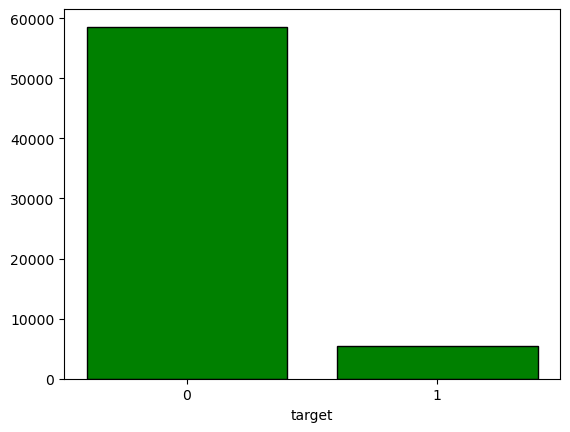

In [6]:
ax = plt.axes()
freq=df['target'].value_counts()
plt.bar(x=[0, 1], height=[freq[0], freq[1]], color='green', ec='black')
plt.xlabel('target')
x_ticks = ax.set_xticks([0, 1])

In [7]:
disbalance = (df['target'] == 0).sum() / (df['target'] == 1).sum()
print(f'Дисбаланс классов: 1 к {round(disbalance, 2)}')

Дисбаланс классов: 1 к 10.81


Поскольку в данных присутствует дисбаланс классов, при обучении модели будет передан специальный вес для меньшего класса, что позволит компенсировать этот дисбаланс.

## 2.2. Дубликаты

In [8]:
df.shape

(64000, 25)

In [9]:
df = df[~df.index.duplicated(keep='first')]

In [10]:
df.shape

(64000, 25)

Дубликаты не найдены.

## 2.3. Выбросы

Проверим признаки с целыми неотрицательными значениями, у которых максимальное значение превышает 75-й квантиль как минимум в 3 раза.

In [11]:
for col in df.columns:
    desc = df[col].describe()
    if desc['max'] - desc['75%'] > df[col].std() * 3:
        print(col)

bankemplstatus
sum
max
median
mean
count
sum_trans_p
currency_other
currency_usd
currency_euro
promt_0
promt_1
promt_2
promt_3
target
mcc_code_nunique
interval_max
mean_interval_tran_in_day


In [12]:
for col in df.columns:
    desc = df[col].describe()
    if desc['25%'] - desc['min'] > df[col].std() * 3:
        print(col)

sum
min
median
mean
sum_trans_m
interval_days


Признаки bankemplstatus, currency_other, currency_usd, currency_euro и target являются категориальными и принимают значения только 0 и 1. Далее проанализируем остальные признаки с помощью гистограмм (вызовы гистограмм для всех признаков были исключены).

In [13]:
df['mean_interval_tran_in_day'].sort_values()[::-1][:10]

user_id
338624    110.000000
249486     44.000000
327158     42.666667
85801      39.750000
134182     37.666667
55472      37.000000
379985     36.500000
119412     36.000000
281187     36.000000
317605     35.200000
Name: mean_interval_tran_in_day, dtype: float64

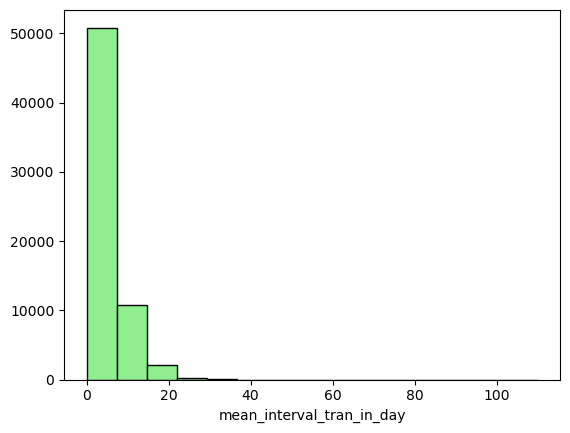

In [14]:
plt.hist(df['mean_interval_tran_in_day'], color='lightgreen', ec= 'black', bins = 15)
plt.xlabel('mean_interval_tran_in_day')
plt.show()

In [15]:
df['count'].sort_values()[::-1]

user_id
233591    1497
122632    1488
18628     1483
147739    1479
54506     1478
          ... 
390154      11
7178        11
146227      11
81151       11
3           11
Name: count, Length: 64000, dtype: int64

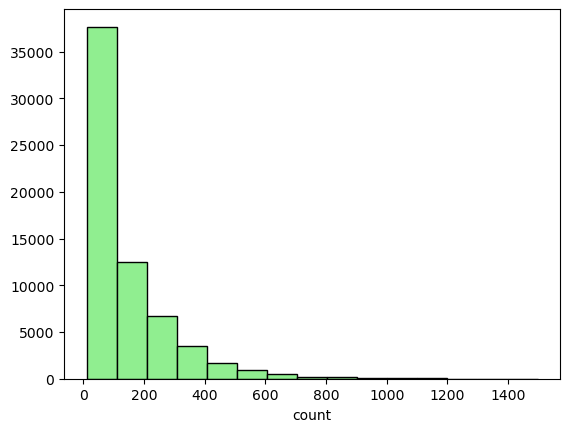

In [16]:
plt.hist(df['count'], color='lightgreen', ec= 'black', bins = 15)
plt.xlabel('count')
plt.show()

Все признаки, за исключением mean_interval_tran_in_day, имеют несколько значений, близких к максимальным, что делает их важными для модели. Однако в признаке mean_interval_tran_in_day был обнаружен один выброс. Значение 75-го квантиля составляет 6.28, тогда как максимальное значение — 110, что превышает квантиль в 17.5 раз. Это говорит о наличии выброса. Поскольку выброс единственный, его удаление предотвратит добавление шума в модель.

In [17]:
df.drop(338624, inplace=True)
df.shape

(63999, 25)

## 2.4. Информативность признаков

Поставим порог 95%.

In [18]:
rows = len(df.index)
low_information = [] 

for col in df.columns:
    unique = df[col].value_counts()
    top = (unique/rows).iloc[0]
    
    if top > 0.95:
        low_information.append(col)
        print(f'{col}: {round(top*100, 2)}%')
        print()

bankemplstatus: 99.68%

currency_usd: 99.86%

currency_euro: 99.82%

promt_2: 99.82%

promt_3: 99.86%



Было выявлено 5 «модных» признаков, в которых одно значение значительно преобладает по количеству над другими. Удалим эти признаки, так как они не предоставляют полезной информации для нашей модели.

In [19]:
df.drop(['bankemplstatus', 'currency_usd', 'promt_2', 'promt_3', 'currency_euro'], axis=1, inplace=True)

## 2.5. Корреляция

In [20]:
corr = df.corr()
(corr > 0.9).sum() - 1

report                       0
employee_count_nm            0
customer_age                 0
sum                          0
max                          0
min                          0
median                       0
mean                         0
count                        1
sum_trans_p                  0
sum_trans_m                  0
unique_days                  1
interval_days                0
currency_other               0
promt_0                      0
promt_1                      0
target                       0
mcc_code_nunique             0
interval_max                 0
mean_interval_tran_in_day    0
dtype: int64

Обнаружены 2 признака, которые коррелируют между собой. Поскольку датасет небольшой, оставим оба признака без удаления.

# 3. Тюнинг модели и подбор параметров

Обучать будем RandomForestClassifier, находящийся в модуле sklearn.ensemble.

Подберём гиперпараметы через библиотеку optuna. Параметры, которые будем подбирать:
1. Количество деревьев (n_estimators).
2. Глубина деревьев (max_depth).
3. Минимальное количество выборок, необходимых для разделения внутреннего узла (min_samples_split).
4. Минимальное количество выборок, необходимых для нахождения в листе (min_samples_leaf).


Метрикой для нашей модели будет ROC-AUC, так как она используется в условиях несбалансированности классов. Если рассматривать точность (accuracy), модель будет всегда показывать минимум 0.9, поскольку соотношение классов составляет 1 к 10. Таким образом, даже при случайном выборе, что клиент не уйдет в отток, вероятность правильной классификации будет равна 0.9.

Для оценки точности модели используем кросс-валидацию. Этот метод позволяет избежать потери данных при оценке модели, обеспечивая более надежные результаты.

In [21]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify=y)

In [22]:
study = optuna.create_study(direction='maximize')

[I 2024-10-14 18:59:08,293] A new study created in memory with name: no-name-a8beb117-82a8-41bf-b3aa-2990674b5e52


In [23]:
def opt(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 150, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'class_weight': {0: 1, 1: disbalance}
    }

    rfc = RandomForestClassifier(n_jobs=18, verbose=1, **params)
    score = cross_validate(rfc, X_train, y_train, cv=5, scoring='roc_auc')
    return score['test_score'].mean()


In [24]:
%%time
study.optimize(opt, n_trials=30)

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=18)]: Done 194 out of 194 | elapsed:    3.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 194 out of 194 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.3s
[Parallel(n_jobs=18)]: Done 194 out of 194 | elapsed:    1.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 194 out of 194 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.3s
[Parallel(n

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done 122 out of 157 | elapsed:    1.6s remaining:    0.4s
[Parallel(n_jobs=18)]: Done 157 out of 157 | elapsed:    2.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 157 out of 157 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 122 out of 157 | elapsed:    2.0s remaining:    0.5s
[Parallel(n_jobs=18)]: Done 157 out of 157 | elapsed:    2.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 157 out of 157 | elapsed:    0.

[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   14.1s
[Parallel(n_jobs=18)]: Done 262 out of 262 | elapsed:   22.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 262 out of 262 | elapsed:    0.2s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   15.7s
[Parallel(n_jobs=18)]: Done 262 out of 262 | elapsed:   23.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 262 out of 262 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend Loky

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   16.3s
[Parallel(n_jobs=18)]: Done 262 out of 262 | elapsed:   23.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 262 out of 262 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   13.4s
[Parallel(n_jobs=18)]: Done 262 out of 262 | elapsed:   21.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tas

[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   15.8s
[Parallel(n_jobs=18)]: Done 298 out of 298 | elapsed:   27.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done 298 out of 298 | elapsed:    0.3s finished
[I 2024-10-14 19:14:52,837] Trial 11 finished with value: 0.7449630968137078 and parameters: {'n_estimators': 298, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 18}. Best is trial 11 with value: 0.7449630968137078.
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   16.3s
[Parallel(n_jobs=18)]: Done 294 out of 294 | elapsed:   27.3s finished
[Parallel(n_jobs=18)]: Usi

[Parallel(n_jobs=18)]: Done 279 out of 279 | elapsed:    0.3s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   14.9s
[Parallel(n_jobs=18)]: Done 279 out of 279 | elapsed:   24.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 279 out of 279 | elapsed:    0.3s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   14.5s
[Parallel(n_jobs=18)]: Done 279 out of 279 | elapsed:   23.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Don

[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 278 out of 278 | elapsed:    0.2s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   15.9s
[Parallel(n_jobs=18)]: Done 278 out of 278 | elapsed:   25.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done 278 out of 278 | elapsed:    0.3s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   17.8s
[Parallel(n_jobs=18)]: Done 278 out of 278 | elapsed:   27.5s finished
[Parallel(n_jobs=18)]: Using backend Threading

[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done 281 out of 281 | elapsed:    0.3s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   16.2s
[Parallel(n_jobs=18)]: Done 281 out of 281 | elapsed:   27.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done 281 out of 281 | elapsed:    0.3s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.2s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   17.2s
[Parallel(n_jobs=18)]: Done 281 out of 281 | elapsed:   27.6s finished
[Parallel(n_jobs=18)]: Using backend Threading

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done 268 out of 268 | elapsed:    0.4s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   15.5s
[Parallel(n_jobs=18)]: Done 268 out of 268 | elapsed:   24.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 268 out of 268 | elapsed:    0.2s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=18)]: Done 164 tas

[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=18)]: Done 283 out of 283 | elapsed:    0.4s finished
[I 2024-10-14 19:44:10,434] Trial 25 finished with value: 0.7446648440765045 and parameters: {'n_estimators': 283, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 18}. Best is trial 13 with value: 0.7460845283126011.
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   16.3s
[Parallel(n_jobs=18)]: Done 231 out of 231 | elapsed:   21.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done 231 out of 231 | elapsed:    0.2s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n

[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 246 out of 246 | elapsed:    0.2s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   10.6s
[Parallel(n_jobs=18)]: Done 246 out of 246 | elapsed:   15.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 246 out of 246 | elapsed:    0.1s finished
[I 2024-10-14 19:49:20,971] Trial 28 finished with value: 0.740431037627172 and parameters: {'n_estimators': 246, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 16}. Best is trial 13 with value: 0.7460845283126011.
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_

CPU times: total: 3min 16s
Wall time: 51min 26s


In [39]:
print('Количество обученных моделей: {}'.format(len(study.trials)))
print('Лучшая модель:')
trial = study.best_trial

print('  ROC-AUC = {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {} = {}'.format(key, value))

Количество обученных моделей: 30
Лучшая модель:
  ROC-AUC = 0.7460845283126011
  Параметры: 
    n_estimators = 292
    max_depth = 15
    min_samples_split = 10
    min_samples_leaf = 20


In [29]:
params = trial.params

# 4. Обучение модели на наилучших параметрах

In [40]:
rfc = RandomForestClassifier(verbose=1,
                             n_jobs=18,
                             n_estimators=292,
                             max_depth=15,
                             min_samples_split=10,
                             min_samples_leaf=20)

In [31]:
score = cross_validate(rfc, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'], return_estimator=True)
print(score['test_roc_auc'].mean())

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   12.8s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:   24.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.3s finished
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=18)]: Done 164 tas

0.7463475353810312


[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.3s finished


In [42]:
conf_matrix = np.array([[0, 0], [0, 0]])
for i in range(len(score['estimator'])):
    y_pred = score['estimator'][i].predict(X_test)
    conf_matrix += confusion_matrix(y_test, y_pred)
    
print('Матрица ошибок:')
print(conf_matrix // 5)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s


Матрица ошибок:
[[5831   26]
 [ 504   37]]


[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.0s finished


In [43]:
test_roc_auc = []
for i in range(len(score['estimator'])):
    test_roc_auc.append(roc_auc_score(y_test, score['estimator'][i].predict_proba(X_test)[:, -1]))

print(f'ROC-AUC на тестовой выборке с кросс-валидацией: {sum(test_roc_auc) / len(test_roc_auc)}')

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Do

ROC-AUC на тестовой выборке с кросс-валидацией: 0.7387671194909287


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 292 out of 292 | elapsed:    0.0s finished


В данной задаче ROC-AUC равный 0.7388 показывает, что модель успешно классифицирует клиентов.

Проверим значимость признаков.

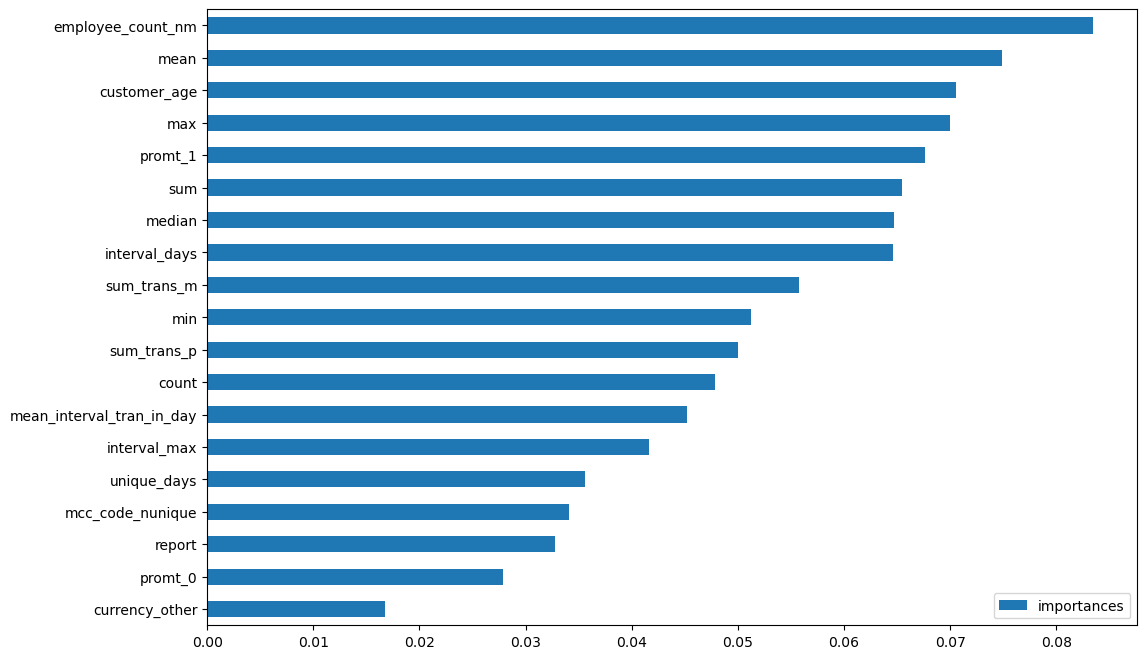

In [36]:
importances = pd.DataFrame(score['estimator'][0].feature_importances_, index=X.columns, columns=['importances'])
importances.sort_values('importances').plot(kind='barh', figsize=(12, 8))
plt.show()

Все признаки значимы.

# 5. Вывод

В результате работы был проанализирован и подготовлен датасет для обучения модели случайного леса. Некоторые признаки были удалены, и добавлены веса к меньшему классу. Модель была настроена для нахождения оптимальных параметров, при этом использовалась кросс-валидация. Проведена проверка значимости признаков, что подтвердило отсутствие неинформативных признаков для модели. В итоге получен ROC AUC = 0.7388, что свидетельствует о достаточной эффективности обученной модели.